This notebook shows an example of a Wilkin-style bowshock model fit (and MCMC analysis), to an image of the J1959+2048. The data and results from this notebook were in a Romani et al., 2022 <a href="https://ui.adsabs.harvard.edu/abs/2022ApJ...930..101R/abstract"> (ADS link here) </a>. <br>

Written by: Martijn de Vries. <br>
Email: martijndevries91@gmail.com

In [16]:
#used python packages. 
import numpy as np
import astropy
import sys
from astropy.io import fits
from matplotlib import pyplot as plt
import scipy
from scipy import optimize
from scipy.ndimage.filters import gaussian_filter
import random
import emcee #MCMC
from numba import jit #numba.jit is very useful to speed up the double for loop in the wilkin_model function
import cProfile
import re
import corner

First of all: the bowshock model <br>
This is based on a paper by Wilkin, 2000 <a href="https://arxiv.org/pdf/astro-ph/0003389.pdf">(arXiv link)</a>. <br>
The function below is the simplest version which assumes a spherical stellar wind.

In [17]:
@jit(nopython=True)
def wilkin_model_jit(imgshape, r0, norm, x_off, y_off, qincl, rot):

    lx, ly = imgshape[:2] #size of the simulated image
    sim_arr = np.zeros((lx, ly))

    #phi is the angle up-down w.r.t. pulsar (0 north of the PSR i.e. in the direction of the apex,
    # pi south of the PSR)
    nphi = 500 #if you increase this the code will take longer but you'll have better  sampling
    ph1 = 0.001
    ph2 = 7.5/8.*np.pi
    phi_range = np.linspace(ph1, ph2, nphi) #array for phi loop

    #theta is the angle going all the way around the bowshock at a given distance in front of/behind the PSR
    nth= 300 #same as nphi
    theta_range = np.linspace(-1*np.pi, np.pi, nth) #array for theta loop, goes in a full circle -pi to pi
    
    #scaling factor (to get sub-pixel sampling), the actual standoff distance r0 in pixels is r0*scl
    scl = 5.5

    #loop over each cylindrical radius shell (function of angle phi)
    for phi in phi_range:
        
        #cylindrical radius (i.e. how far ahead/behind the PSR are we on the motion axis)
        #is a function of standoff distance r0 and phi
        r=  r0/np.sin(phi) * (3.*(1-(phi/np.tan(phi))))**0.5
                  
        for theta in theta_range:
            
            #at each cylindrical radius loop around full circle
            czeta = np.cos(phi)*np.cos(qincl)  + np.sin(phi)*np.sin(qincl)*np.cos(theta)
            schi= np.sin(phi)* np.sin(theta)/(1-czeta**2)**0.5

        
            sw = np.sin(theta)*np.sin(qincl)/np.sin(phi)
            szeta = np.sin(theta)*np.sin(phi)/schi
            cchi = (np.cos(phi)- czeta*np.cos(qincl))/(szeta*np.sin(qincl))

            chi= np.arcsin(schi)
            if (cchi > 0): chi= np.pi - chi
            
            zeta=np.arccos(czeta)
        
            #convert to actual x,y pixs on the image
            xx=r*np.sin(zeta)*np.cos(chi) 
            yy=r*np.sin(zeta)*np.sin(chi)

            ix= (xx*scl) + lx/2. 
            iy= (yy*scl) + ly/2. 
 
            #rotation
            ix_r = (ix-lx/2)*np.cos(rot) - (iy-ly/2.)*np.sin(rot) + lx/2.
            iy_r = (ix-lx/2)*np.sin(rot) + (iy-ly/2.)*np.cos(rot) + ly/2.
            
            amp = r*np.sin(phi)
            amp *= 2.5+1.5*np.exp(0.5*(phi-ph1)**2)
            
            ix_r += x_off
            iy_r += y_off
            
            #This just excludes pixels outside of the image bounds
            if (ix_r >= lx) or (ix_r < 0 ) or (np.isfinite(ix_r) == False): continue 
            if (iy_r >= ly) or (iy_r < 0 ) or (np.isfinite(iy_r) == False): continue 
            
            sim_arr[int(ix_r),int(iy_r)]+= amp*norm
        
    #blur with a gaussian so that the model matches the spatial resolution of your observation.
    #Note: the 0.7 (pixel) is the spatial resolution of HST (the guitar data)
    #you'll have to calculate or look up what it is for your observations
    
    #add flat bkg level 
    return sim_arr


def wilkin_model(imgshape, r0, norm, bkg, x_off, y_off, qincl, rot):
    sim_arr = wilkin_model_jit(imgshape, r0, norm, x_off, y_off, qincl, rot)
    
    #blur with a gaussian so that the model matches the spatial resolution of the observation.
    #for J1959, the PSF width corresponds to 1.9 pixels on the image
    #add flat bkg level 
    sim_arr_sm = gaussian_filter(sim_arr, sigma=1.9) + bkg
    return sim_arr_sm

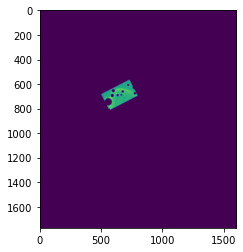

In [18]:
#This cell loads the data, 

hdu_1959 = fits.open("Ha-combined.fits")

#this is the full data
data_1959_raw = hdu_1959[0].data
data_plot = np.zeros(data_1959_raw.shape)
data_plot[:,:] = data_1959_raw[:,:]

#error in each pixel
sum_err_1959_raw = fits.open("stddev.fits")[0].data

#mask
hdu_mask = fits.open('J1959mask2.fits')
mask_data = hdu_mask[0].data

#'pixl' is the list of pixels that are used in the analysis (so include rather than exclude)
#this is passed down to the likelihood object further down so it knows which pixels to use
pixl = np.where(mask_data == 1)
pix_exclude = np.where(mask_data == 0) #this is the exclude
data_plot[pix_exclude] = 0

plt.imshow(data_plot)
plt.show()



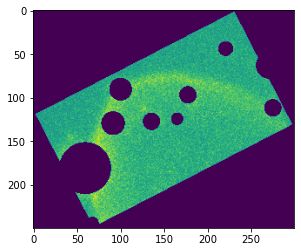

In [19]:
#Cutting the image down to a smaller size
xlo = 565
ylo = 495
xhi = 815
yhi = 795
plt.imshow(data_plot[xlo:xhi,ylo:yhi])
plt.show()

In [20]:
#These cuts look good
#bin_1959 and err_1959 are the variables that can be passsed through to the rest of the analysis
#you can also edit the cuts if you like
bin_1959 = data_1959_raw[xlo:xhi,ylo:yhi] 
bin_error = sum_err_1959_raw[xlo:xhi,ylo:yhi]
new_plot_1959 = data_plot[xlo:xhi,ylo:yhi]


#this makes the new list of include/exclude pixls in the cut image
pixl = np.where(new_plot_1959 > 0)
pix_exclude = np.where(new_plot_1959 == 0)


In [21]:
logmin = 1e10

#I tend to put all the fitting stuff into a class, it makes it easier to organise and modify things
#Depending on your fitting problem, there can be a lot of bookkeeping involved
class GaussianPosterior(object):
    
    #this is all the info the fitting object needs when you instantiate it
    def __init__(self, data, sigma, model, priors, xpix, ypix, par_switches, offsets=None, incset=None, rotset=None):

        #anything stored into self can be used by the other attributes of the object after you instantiate
        self.imsize = data.shape
    
        self.priors = priors #priors lower and upper boundaries
        self.model = model #the image model (in this case that's going to be the wilkin_model above)
        self.data = data
        self.sigma = sigma
        
        #You probably don't want to fit the entire image that you load in, so I've set it up so that you can
        #give a list of the x and y-indices to define which pixels you want to include in the fit
        #(I'll include an example further down below)
        self.xpix = xpix 
        self.ypix = ypix
    
        #because we don't use all pixels in the image and therefore don't have a neat 2d square array,
        #I 'ravel' all the pixels that we want to include into one long 1-d array
        # you then compare with the ravelled model array
        self.ravdata = np.ravel(data[xpix, ypix])
        self.ravsigma = np.ravel(sigma[xpix, ypix])

    
        #switching parameters on and off as fixed parameters
        #these should be True or False
        self.posfix = par_switches[0]
        self.incfix = par_switches[1]
        self.rotfix = par_switches[2]
        
    
        self.offsets = offsets
        self.incset = incset
        self.rotset = rotset
        
        #if offset, inclination, or rotation are fixed, the class expects pre-set values for these
        if self.posfix == True:
            if not self.offsets:
                sys.exit('You set the x and y offset to be fixed. Please pass an offset tuple [x,y] with the offsets keyword when instantiating the GaussianPosterior class')
        if self.incfix == True:
            if not self.incset:
                sys.exit('You set the inclination to be fixed, please pass an inclination with the incset keyword when instantiating the GaussianPosterior class')
        if self.rotfix == True:
            if not self.rotset:
                sys.exit('You set the rotation to be fixed, please pass a rotation with the rotset keyword when instantiating the GaussianPosterior class')

        
    def logprior(self, pars):
        
        r0 = pars[0]
        norm = pars[1]
        bkg = pars[2]
        
        x_off = pars[3]
        y_off = pars[4]
        incl = pars[5]
        rot = pars[6]
        
        #if x_off, y_off, inc and rot are fixed,
        #overwrite them with the fixed values
        if self.posfix == True:
            x_off = self.offsets[0]
            y_off = self.offsets[1]
        
        if self.incfix == True:
            incl = self.incset
        
        if self.rotfix == True:
            rot = self.rotset
            
        # Here you can define priors on the parameters
        # In this ex. i've only included uniform (or 'flat') priors, basically just an upper and a lower boundary

        pb = self.get_priorbounds() #these are the ones getting fed to the class when you instantiate GaussianPosterior
        p_r0 = (r0 > pb[0][0]) & (r0 < pb[0][1])
        p_norm = (norm > pb[1][0])
        p_bkg = (bkg > pb[2][0]) & (bkg < pb[2][1])
        p_xoff = (x_off > pb[3][0]) & (x_off < pb[3][1])
        p_yoff = (y_off > pb[4][0]) & (y_off < pb[4][1])
        p_incl = (incl > pb[5][0]) & (incl < pb[5][1])
        p_rot = (rot  > pb[6][0]) & (rot < pb[6][1])

        logprior = np.log(p_r0 * p_bkg * p_norm * p_incl * p_rot * p_xoff * p_yoff)
    
        #whenever one of the parameters is outside of the boundary, logprior becomes infinite
        #in that case, return the 'logmin' value as defined up above, which tells the algorithm that this
        #parameter value is incredibly unlikely, so it'll be pushed to move that par. back within your prior boundaries
        if not np.isfinite(logprior):
            return logmin
        else:
            return logprior

    def get_priorbounds(self):
        
        return self.priors
    
    def loglikelihood(self, pars):
        
        #This is the likelihood function from Bayesian statistics (i.e., how likely is the data given the model)
        #First get the model values
        model_vals = self.get_ravmodel(pars)

        #equation for the log-likelihood assuming your data points have Gaussian errors
        #(which we are assuming in this case)
        #this is basically equivalent to least-squares regression
        #(i.e. note the (data-model)**2/sigma**2 term at the end)
        ll = len(self.ravdata)/2. * np.log(2*np.pi*np.median(self.ravsigma)**2)  \
                + np.sum( (self.ravdata-model_vals)**2 / (2*self.ravsigma**2))
        
        #this shouldnt happen but if for some reason the LL is infinite, just make it very unlikely
        if not np.isfinite(ll):
            ll = logmin
        return ll
    
    def logposterior(self, pars,  neg=False, verbose=False):
        
        #the posterior is the multiplication of the prior and the likelihood functions (in log-space, the sum)
        #this is the function we are actually trying to optimize/minimize (or sample, in case of MCMC)
        lp = self.logprior(pars)
        ll = self.loglikelihood(pars)
        lpost = lp + ll
        
        if verbose == True:
            print('-----')
            print('logprior:', lp, 'll:', ll, 'lpost:', lpost)
            print('pars:', pars)
        
        #the neg switch makes it so you can either optimize (the log-posterior) or minimize (the negative log-posterior)
        if neg is True:
            return lpost
        else:
            return -lpost       
    
    def get_ravdata(self):
        #return ravelled data
        return self.data, self.sigma
    
    def get_ravmodel(self, pars):
        
        r0 = pars[0]
        norm = pars[1]
        bkg = pars[2]
        
        x_off = pars[3]
        y_off = pars[4]
        incl = pars[5]
        rot = pars[6]
        
            
        #if x_off, y_off, inc and rot are fixed,
        #overwrite them with the set fixed values
        if self.posfix == True:
            x_off = self.offsets[0]
            y_off = self.offsets[1]
        
        if self.incfix == True:
            incl = self.incset
        
        if self.rotfix == True:
            rot = self.rotset
            
        model_arr = self.model(self.imsize, r0, norm, bkg, x_off, y_off, incl, rot)
        ravmodel = model_arr[self.xpix, self.ypix]
    
        return ravmodel
    
    def __call__(self, pars, neg=False, verbose=False):
        return self.logposterior(pars, neg, verbose)
    
    

        

In [22]:
#now we have everything we need, we can create fitting object, which is an instance of the GaussianPosterior class

#pass Boolean switches for 1) x and y offsets, 2) inclination, and 3) rotation
#if True, the parameter is fixed
#if the switch is True, when you instantiate GaussianPosterior you should also pass a pre-set value for that par
#eg.
par_switches = [False, True, False]
offset_preset = [-4, -8]
inc_preset = 1.6
rot_preset = 0.55

#lower and upper boundaries for each par
#par order: r0, norm, bkg, x_off, y_off, inc, rot
priorbounds = [[1, 12], [0, None], [0, 20], [-50, 50], [-50, 50], [1.3, 1.9], [0.3, 0.9]]

#the error image from Chase gives the strange-looking MCMC walkers
#just taking the square root of the data does work
alt_error = np.sqrt(bin_1959)
lpost = GaussianPosterior(bin_1959, alt_error, wilkin_model, priorbounds, pixl[0], pixl[1], par_switches=par_switches, \
                        offsets=offset_preset, incset=inc_preset, rotset=rot_preset)


#initial guesses for parameters
#par order: r0, norm, bkg, x_off, y_off, inc, rot
#make sure these guesses fall between the boundaries on your priors
#otherwise the likelihood is already bad from the first call and the minimizer probably won't know
#which region of parameter space to wander into, because all likelihoods will be equally bad
#when you fix the parameters, you still need to pass the parameter in guess_pars
#(just cause it's a bit of a hassle to code the Posterior class above to expect all possible combinations of fixed/free parameters)
#but the parameter won't have any effect, it will be overwritten at every iteration with the preset above
guess_pars = [5.5, 2e-3, 17, 8.5, -15, 0.4, 0.65]


#so what we'll be doing here is minimizing the negative log-likelihood
#any kind of fitting that deals with optimizing/minimizing the likelihood is called Maximum Likelihood Estimation
#or MLE.
fitmethod = scipy.optimize.minimize
neg = True
#if you set verbose to True, it will print the value of the logprior, loglikelihood and logprior at every iteration
#as well as the parameters that it is trying
verbose=False 

#Now do the actual fitting. You can see below that we are passing the fitting object (lpost) to the minimizer
#The '__call__' attribute is then automatically called, which we have set to return the logposterior value, 
#which scipy.optimize.minize then attempts to minize
#also note, there are several different methods that you can use, here I've used 'Powell' but 
#it's probably worth looking at the scipy.optimize.minimize documentation and looking at the different methods
#they have different (dis)advantages and requirements
#they also return different results objects 
#(some will return the inverse Hessian from which you can estimate the covariance for example)
results = fitmethod(lpost, x0=guess_pars, tol=1e-3, method='Powell', options={'maxiter':10000}, args=(neg,verbose))



<ipython-input-21-61be501dde17>:89: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(p_r0 * p_bkg * p_norm * p_incl * p_rot * p_xoff * p_yoff)


In [23]:
#the 'results' object has several different attributes of itself
print(results)
#in our case, we'll want the best-fit vals which you can access as results.x
bestfit_pars = results.x
#if we fixed some parameters, we want to overwrite the best-fit parameters for those with the pre-set values
if par_switches[0] == True:
    bestfit_pars[3] = offset_preset[0]
    bestfit_pars[4] = offset_preset[1]
if par_switches[1] == True:
    bestfit_pars[5] = inc_preset
if par_switches[2] == True:
    bestfit_pars[6] = rot_preset


   direc: array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])
     fun: 78777.94146562525
 message: 'Optimization terminated successfully.'
    nfev: 149
     nit: 2
  status: 0
 success: True
       x: array([ 9.03681713e+00,  4.90902284e-03,  1.70109102e+01,  7.26393205e+00,
       -1.55066173e+01,  4.87213593e+00,  6.56384388e-01])


In [24]:
#print paramaters:
parnames = ['r0', 'norm', 'bkg', 'x_off', 'y_off', 'incl', 'rot']

for i in range(len(parnames)):
    parstr = ""
    if i == 4:
        if par_switches[0] == True:
            parstr += "FIXED par:"
    if i == 5:
        if par_switches[1] == True:
            parstr += "FIXED par:"
    if i == 5:
        if par_switches[2] == True:
            parstr += "FIXED par:"
    parstr+= str(parnames[i]) + ': ' + str(bestfit_pars[i])
    print(parstr)

r0: 9.036817126879482
norm: 0.004909022836376703
bkg: 17.010910203154378
x_off: 7.263932050312
y_off: -15.506617284579287
FIXED par:incl: 1.6
rot: 0.6563843875577807


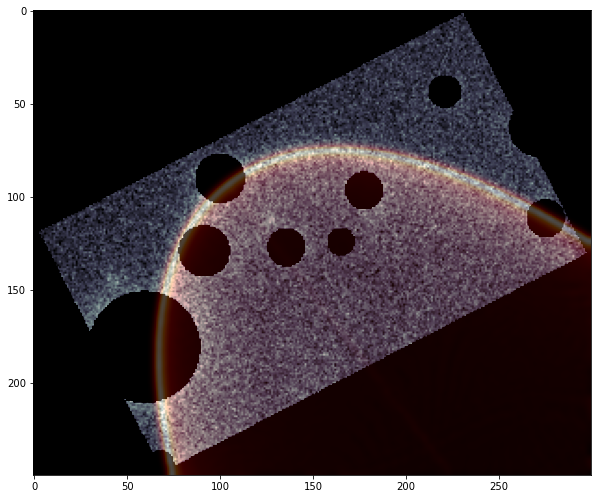

In [25]:
#plot overlay of model on top of data
wilkin1 = wilkin_model(bin_1959.shape, *bestfit_pars)
plt.figure(figsize = (10,10))
plt.imshow(new_plot_1959, vmin=13, vmax=25, cmap='bone')
plt.imshow(wilkin1, alpha=0.3, cmap='gist_heat')
plt.show()



In [26]:
#function to plot the data and the results side by side

def make_results_plot(data, fitpars, xpix, ypix):
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    data_plot= np.zeros(data.shape)
    data_plot[xpix, ypix] = data[xpix, ypix]
    
    model_arr = wilkin_model(data.shape, *fitpars)
    
    model_plot = np.zeros(data.shape)
    model_plot[xpix, ypix] = model_arr[xpix, ypix]
    
    axes[0].imshow(data_plot, vmin=13, vmax=25, cmap='bone')
    axes[1].imshow(model_plot, alpha=1, cmap='gist_heat')
    
    plt.show()
    return

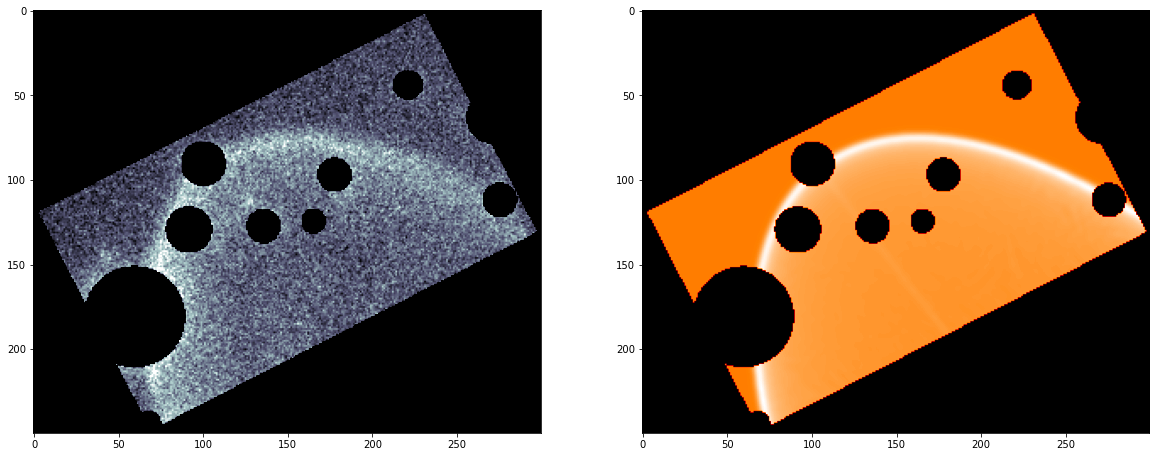

In [27]:
#side by side plot
make_results_plot(bin_1959, bestfit_pars, pixl[0], pixl[1])

In [28]:
#convert xoff, yoff to pulsar image coords:

x_off = bestfit_pars[3]
y_off = bestfit_pars[4]

x_img = (xhi-xlo)/2 + x_off + xlo
y_img = (yhi-ylo)/2 + y_off + ylo

print('Pulsar image coordinates in ds9 should be:', y_img, x_img)


Pulsar image coordinates in ds9 should be: 629.4933827154207 697.263932050312


7


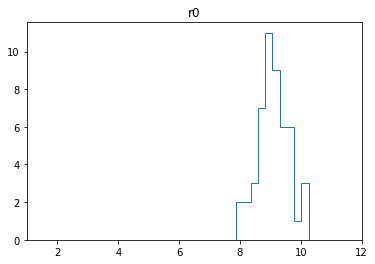

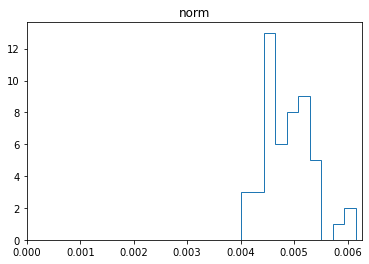

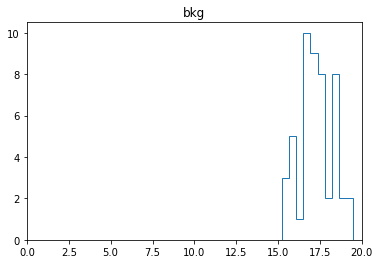

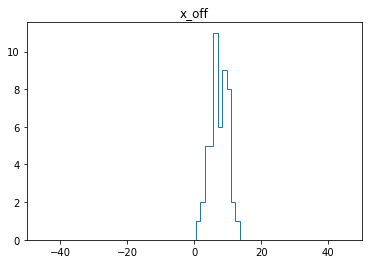

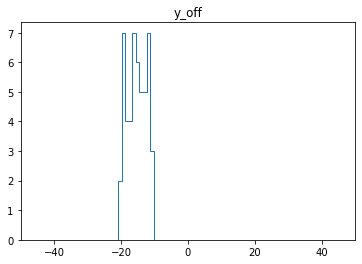

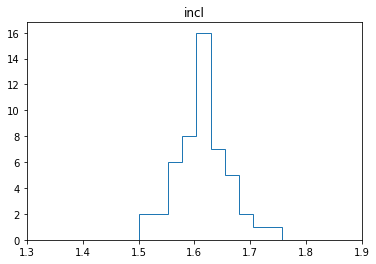

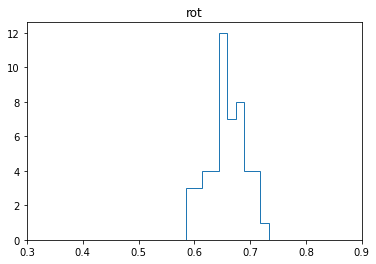

In [31]:
#this is the number of walkers, it should be at least 2x the number of free parameters in the model
#the more walkers, the slower the mcmc sampler will run
#I did 50, but you could actually decrease it (maybe to 30 or so) to let it run a little faster
nwalkers = 50

#number of parameter samples for each walker. So the total nr ofsamples you get is nwalkers *niter
niter = 10000

#as starting parameters, we use the best-fit parameters from the optimizer
start_pars = bestfit_pars 
ndim = len(start_pars)
print(ndim)

#because of how this algorithm works, you can't start them all at the start_pars values 
#because then the distance between all walkers would be zero
#the stepsize would be zero too and nothing would movea
#instead you start them in some normal distribution around the best-fit value
#and pass this to the sampler as  2D array, that we will call p0
p0 = np.zeros((nwalkers, ndim))

#we also need the sigma for each parameter for starting pars. These vals are kinda arbitrarily chosen
#in general it's probably better to have a small sigma (compared to the paramater value)
#and then let the walkers 'expand into' the posterior distribution from there, rather than the other way around
#par order: r0, norm, bkg, x_off, y_off, incl, rot
par_sig = [0.5, 5e-4, 1, 3, 3, 0.05, 0.03]

for q in range(ndim):
    # for each walker, chooses random starting parameters based on start_pars and par_sig
    #scipy.stats.norm generates a random value picked from the normal distribution 
    p0[:,q] = scipy.stats.norm.rvs(loc=start_pars[q], scale=par_sig[q], size=nwalkers)

    
#additionally, we also have to make sure that none of the walkers start outside of the prior boundaries
#because then they probably wont be able to find their way into the correct region of parameter space
#get priorbounds from the model for all pars
pb = lpost.get_priorbounds()
parnames = ['r0', 'norm', 'bkg', 'x_off', 'y_off', 'incl', 'rot']

for i in range(7):
    # clip makes sure everything is within the prior bounds
    p0[:,i] = np.clip(p0[:,i], pb[i][0], pb[i][1]) 

    
    #check that the samples being fed to the MCMC sampler are indeed distributed nicely
    #and not all pushed against the prior boundary or something
    plt.title(parnames[i])
    plt.hist(p0[:,i], bins=10, histtype='step')
    
    #set prior boundaries as xlimits so it's clear how far the pars are distributed throughout the prior
    plt.xlim(pb[i][0], pb[i][1])
    
    plt.show()

In [33]:
#now initialize the sampler and start it

#note how we pass the likelihood object 'lpost' to the sampler, in a similar manner
#as we did for the optimizer above

#also, the keyword 'progress' comes in handy
#once it starts running it should give you a progress bar and estimate of how much time it's going to take

sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost)
sampler.run_mcmc(p0, niter, progress=True, rstate0=np.random.get_state())

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-21-61be501dde17>:89: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(p_r0 * p_bkg * p_norm * p_incl * p_rot * p_xoff * p_yoff)
100%|██████████| 10000/10000 [2:00:55<00:00,  1.38it/s]


State([[ 8.69047976e+000  4.56556211e-003  1.70735401e+001  5.86628450e+000
  -1.84087332e+001 -2.98117728e+129  6.76751832e-001]
 [ 8.69936856e+000  4.73751308e-003  1.69923451e+001  5.62865150e+000
  -1.84852220e+001 -3.81883611e+129  6.78536188e-001]
 [ 8.46670920e+000  4.63987576e-003  1.70425640e+001  4.78072607e+000
  -2.07404698e+001 -9.80976722e+129  6.87635366e-001]
 [ 8.67216044e+000  4.93774751e-003  1.69799899e+001  6.49873573e+000
  -1.89755111e+001  2.73011308e+128  6.84182764e-001]
 [ 8.59027569e+000  4.78311349e-003  1.69712968e+001  5.15639918e+000
  -1.89163196e+001 -1.07019366e+129  6.71003390e-001]
 [ 8.64863813e+000  4.66850658e-003  1.70223042e+001  4.32829354e+000
  -1.75268868e+001 -7.10613126e+129  6.59834099e-001]
 [ 8.63680081e+000  4.87602764e-003  1.69269555e+001  4.66533783e+000
  -1.76761487e+001  3.09736314e+129  6.56675679e-001]
 [ 8.51715926e+000  4.66964666e-003  1.70233060e+001  4.48637822e+000
  -1.92509124e+001 -1.91378768e+127  6.71959256e-001]
 [

In [34]:
#done! Now we can inspect the output
#The first thing we should do is look at the actual chains
#This just shows the sampled parameter value at each iteration, for each individual chain
#and  for each individual parameter

chains=sampler.get_chain()
print(chains.shape)

af = sampler.acceptance_fraction
print("Mean acceptance fraction:", np.mean(af))


(10000, 50, 7)
Mean acceptance fraction: 0.4058059999999999


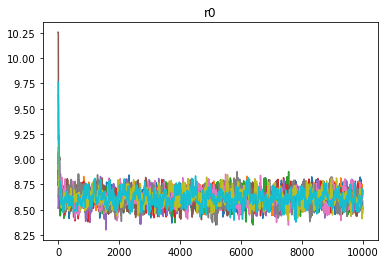

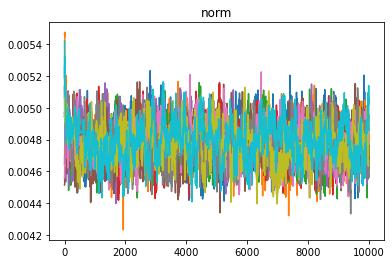

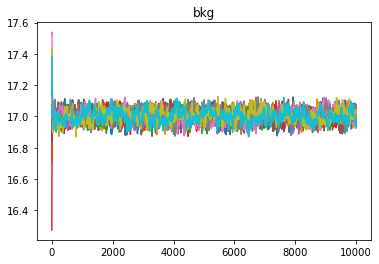

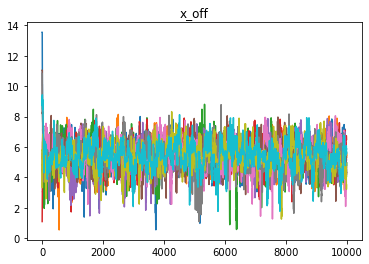

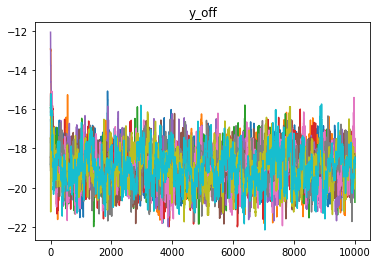

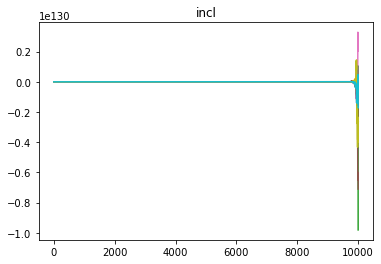

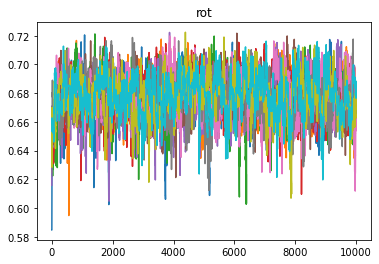

In [35]:
# You can see that the chains array is a 3D array with dimensions [niter, nwalker, npars]
# We can plot what some of the chains were doing for the parameters
# I usually plot around 10 chains or so, it gets messy if you have to plot all of them

#NOTE: the chains are for all parameters, also the ones you might have fixed further up
#Those chains will look very weird, they basically will wander around with larger and larger steps
#But you can safely ignore them since those pars don't contribute anything to the loglikelihood
pars = ['r0', 'norm', 'bkg', 'x_off', 'y_off', 'incl', 'rot']
for j in range(7):
    plt.title(pars[j])
    for i in range(10):
        
        plt.plot(chains[:,i,j])
    plt.show()
    
    

So what do we want to see in these chains?
What we are looking for is for the chains to be 'converged'. Which basically means that the posterior distribution for each parameter will not change anymore, even if you'd let the walkers sample infinitely long.
Signs that the MCMC chains have converged: <br>
1) the chains mix with each other <br>
2) they are all walking through the parameter space in roughly the same fashion <br>
3) the chains oscillate around the same value (i.e. there is no broader trend visible anymore) <br>
4) the chains have oscillated up and down around this average a few times <br>
    
If you read that intro that I linked all the way up top, you'll also have read about something called burnin. This is basically the first part of the sampling process, where the walkers are still 'finding their way' to the optimal region of the parameter space (i.e. condition 3 above is not satisfied yet). If you are smart about your starting parameters, the burnin shouldn't take too long because you should have already started pretty close to this optimal region.
    
You could set up the MCMC such that it first does a 'burnin run', discards those samples, and then starts the real run, but I personally prefer to just look at all the samples. Then you can decide after the fact from what point you trust the samples. Deciding if your chains are converged, and how much burnin to cut off is a little bit of an art more than a science. In the chains above, you can see that apparently I started the bkg way too low, so the chains take a while to get to the preferred value. 

In the chains above, what you also see is that some of the chains are hitting the prior boundary, especially in y_off and in incl. In the case of incl this is fine, we know the inclination in the model isnt very constraining and for the guitar specifically we have information from other observations that does constrain it. For y_offset, it seems that I may have put too strict of a boundary on it. 

Last point I wanted to make here: the way I've set it up now, you can't check the output until it is done. However, there is a way to save the output to something called a 'h5' file, where every sample is written out to the file as it is sampling. That way, you could e.g. let it run for 10,000 samples, periodically inspect the output while it's running (you'd have to do that in another notebook or python script, since this one is already running something of course), and just manually kill the process when you think the chains are converged. There's a tutorial about h5 output in the emcee documentation here https://emcee.readthedocs.io/en/stable/tutorials/monitor/
It's pretty easy to set up, you just need an extra package (h5py).
 

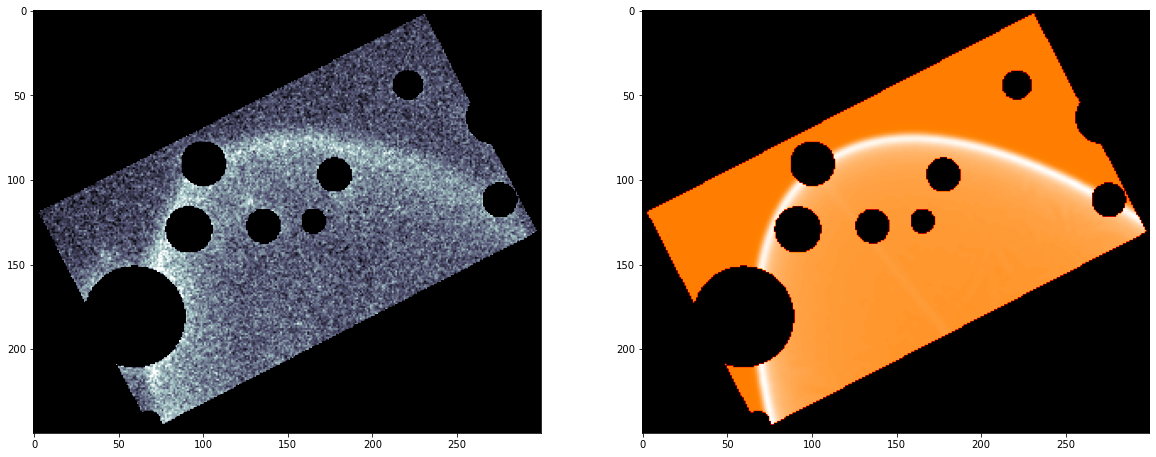

[8.619805375168086, 0.004783619126578657, 17.00073937768021, 5.406883182499731, -18.951760683717513, 1.6, 0.6775893431066644]


In [36]:
#We can get a 'flatchain' which merges the samples from all walkers together 
flatchain = sampler.flatchain

#and then cut out the first 200*nwalker samples.
#Note I think this is probably not conservative enough, but since I only did niter=500 I just use this
good_flatchain = flatchain[200*nwalkers:,:]

#First we can verify that the posterior distributions are indeed sensible,
#y plotting what the model looks like taking the median of very parameter posterior distribution
mcmc_res = []
for i in range(7):
    mcmc_res.append(np.median(good_flatchain[:,i]))
    
#overwrite the fixed-pars with presets
if par_switches[0] == True:
    mcmc_res[3] = offset_preset[0]
    mcmc_res[4] = offset_preset[1]
if par_switches[1] == True:
    mcmc_res[5] = inc_preset
if par_switches[2] == True:
    mcmc_res[6] = rot_preset

make_results_plot(bin_1959, mcmc_res, pixl[0], pixl[1])
print(mcmc_res)

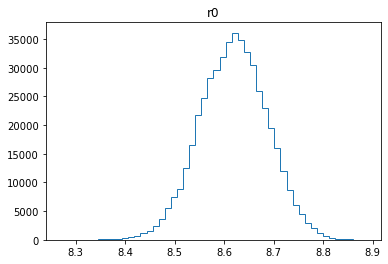

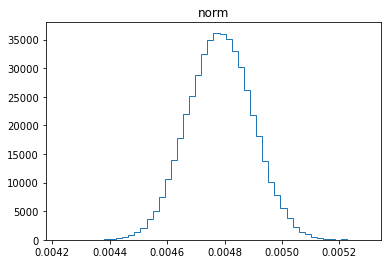

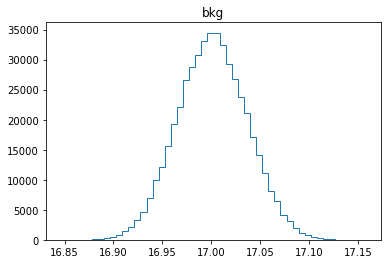

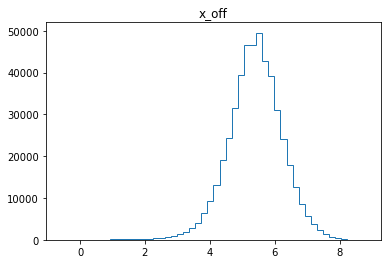

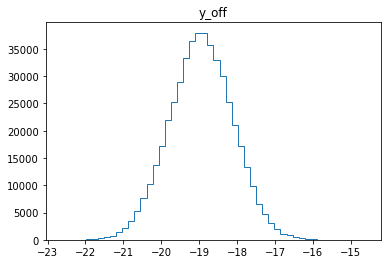

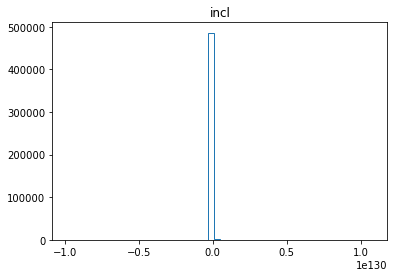

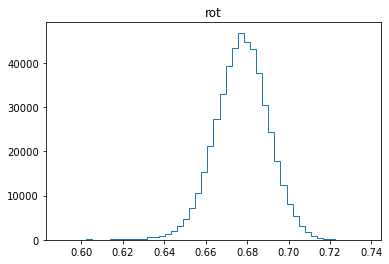

In [37]:
#Then, we can look at the actual posterior distributions

for i in range(7):
    plt.title(pars[i])
    plt.hist(good_flatchain[:,i], bins=50, histtype='step')
    
    plt.show()

In [38]:
#From these distributions we can get errors pretty easily! 
#If the distributions are gaussian, you can think in terms of 1 sigma, 2 sigma etc
#e.g. 1 sigma would correspond to the 14th and 86th percentile of the distribution in that case
#Since often the distribution aren't Gaussian, we quote 'confidence intervals'
#Eg the r0 90% confidence interval would be the value of r0 between the 5th and the 95th percentile
#of the posterior distribution

def confidence(var):
    var_list = ['r0', 'norm', 'bkg', 'x_off', 'y_off', 'incl', 'rot']
    i = var_list.index(var)
    var_med = np.round(np.median(good_flatchain[:,i]), 3)
    var_min = np.round(var_med - np.percentile(good_flatchain[:,i], 5),3)
    var_max = np.round(np.percentile(good_flatchain[:,i], 95) - var_med, 3)
    print(f"The 90% confidence interval of {var} is {var_med}_({var_min})^({var_max})")

confidence('r0')
confidence('norm')
confidence('bkg')
confidence('x_off')
confidence('y_off')
confidence('rot')

The 90% confidence interval of r0 is 8.62_(0.114)^(0.109)
The 90% confidence interval of norm is 0.005_(0.0)^(-0.0)
The 90% confidence interval of bkg is 17.001_(0.058)^(0.059)
The 90% confidence interval of x_off is 5.407_(1.388)^(1.307)
The 90% confidence interval of y_off is -18.952_(1.389)^(1.367)
The 90% confidence interval of rot is 0.678_(0.022)^(0.02)


['r0', 'norm', 'bkg', 'x_off', 'y_off', 'incl', 'rot']


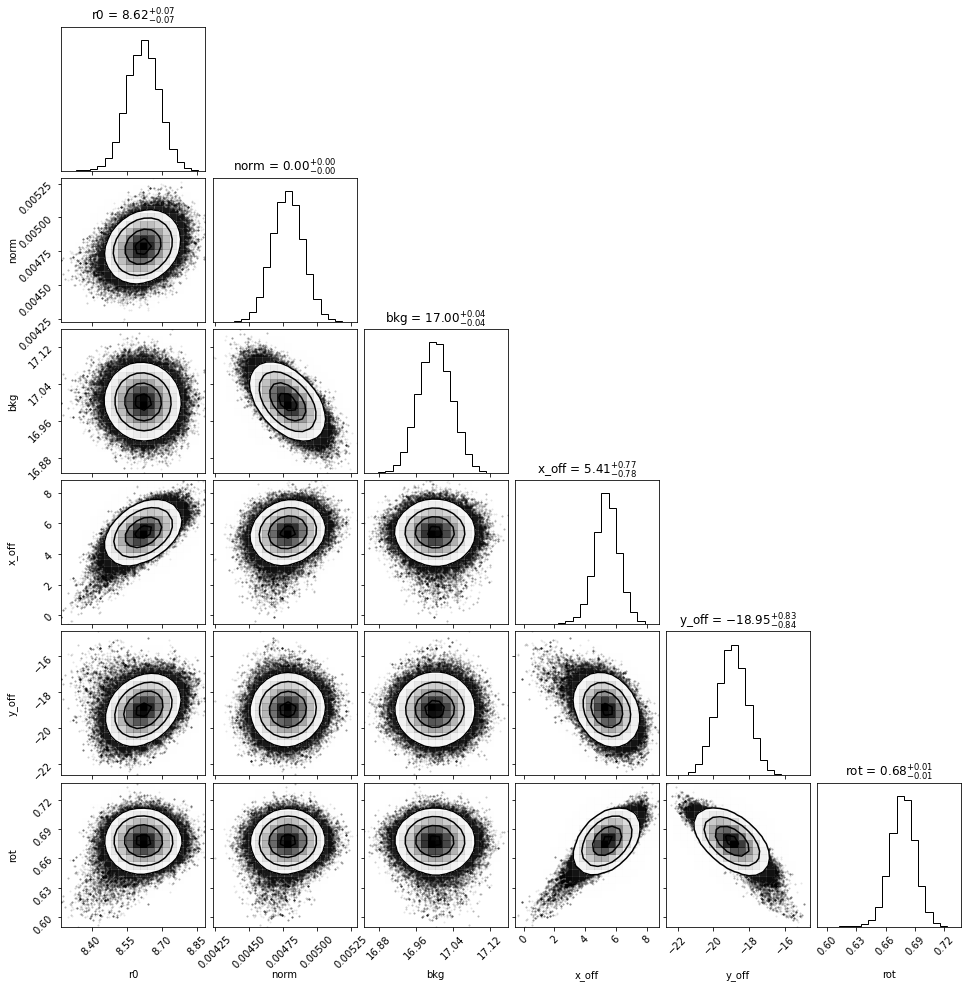

In [39]:
#Last but not least: one easy way to look at the covariances between parameters is to use corner plots
#We can do that with the corner package
#You can then make corner plots easily by:
#This way you can see how all the parameters in the model relate to each other
#So you have a better handle on what's going on
#in the above example, I've fixed inclination so I'll leave that out of this cornerplot
print(parnames)
parnames_f = parnames[0:5] + ['rot']
fig = corner.corner(good_flatchain[:,[0,1,2,3,4,6]], labels=parnames_f, show_titles=True, smooth=1.5)